In [2]:
# trained all experiments with 20 feature RFE : good 
# streamlined the process and the feature selection 

In [2]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
import optuna
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, make_scorer
from joblib import dump, load
from scipy.stats import shapiro
from scipy.stats import ttest_rel
from scipy.stats import levene
import seaborn as sns
from scipy.stats import kurtosis, skew
from sklearn.model_selection import learning_curve

In [4]:
selected_features = ['seller_id', 'product_like_count_sum', 'price_usd_max',
       'seller_price_mean', 'seller_earning_sum', 'seller_products_sold',
       'seller_community_rank', 'seller_num_followers', 'sold', 'in_stock',
       'avg_product_name_length', 'avg_product_keywords_length',
       'products_listed_to_sold_ratio', 'product_type_most_common_target_enc',
       'brand_name_most_common_target_enc', 'seller_country_target_enc',
       'seller_badge_Expert', 'seller_badge_Trusted',
       'usually_ships_within_most_common_3-5 days',
       'usually_ships_within_most_common_unknown']

In [5]:
X_train = pd.read_csv("X_train.csv")[selected_features]  # Applying RFE selected features
y_train = pd.read_csv("y_train.csv").squeeze()
X_test = pd.read_csv("X_test.csv")[selected_features]   
y_test = pd.read_csv("y_test.csv").squeeze()

In [5]:
# Initialize the DecisionTreeRegressor
dt_model = DecisionTreeRegressor(max_depth=10, random_state=42)  # Adjust max_depth as needed

# Define the desired number of features to select
n_features_to_select = 20

# Initialize RFE with DecisionTreeRegressor as the estimator
rfe = RFE(estimator=dt_model, n_features_to_select=n_features_to_select, step=2)

In [ ]:
# Fit RFE on the training data
rfe.fit(X_train, y_train)

In [16]:
# Get the selected features
selected_features = X_train.columns[rfe.support_]
print("Selected Features:")
print(selected_features)

# Create new DataFrames with only the selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Print the shape of the new dataset with selected features
print("Shape of X_train with selected features:", X_train_selected.shape)
print("Shape of X_test with selected features:", X_test_selected.shape)


Selected Features:
Index(['seller_id', 'product_like_count_sum', 'price_usd_max',
       'seller_price_mean', 'seller_earning_sum', 'seller_products_sold',
       'seller_community_rank', 'seller_num_followers', 'sold', 'in_stock',
       'avg_product_name_length', 'avg_product_keywords_length',
       'products_listed_to_sold_ratio', 'product_type_most_common_target_enc',
       'brand_name_most_common_target_enc', 'seller_country_target_enc',
       'seller_badge_Expert', 'seller_badge_Trusted',
       'usually_ships_within_most_common_3-5 days',
       'usually_ships_within_most_common_unknown'],
      dtype='object')
Shape of X_train with selected features: (113157, 20)
Shape of X_test with selected features: (28290, 20)


In [ ]:
# Rename X_train_selected to X_train
X_train = X_train_selected

# Rename X_test_selected to X_test
X_test = X_test_selected

# Verify the new variable shapes
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


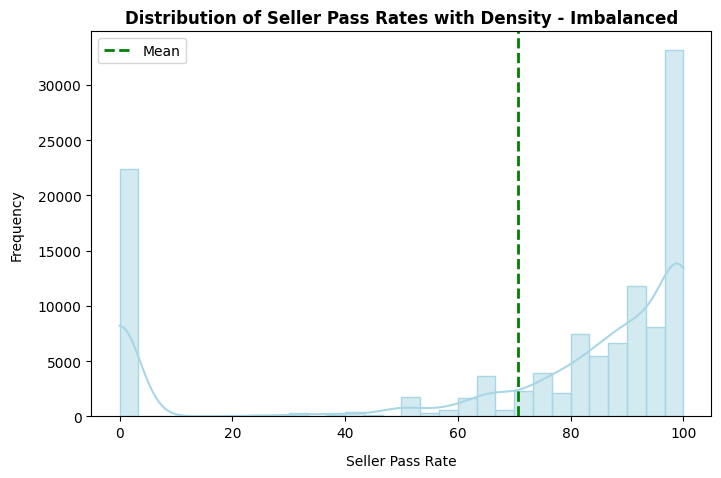

In [48]:

# Plot histogram and density
plt.figure(figsize=(8, 5))
sns.histplot(y_train, kde=True, bins=30, color='#A9D6E5', edgecolor='#A9D6E5')

# Adjust labels and title for readability
plt.xlabel('Seller Pass Rate', labelpad=10)  # Increase font size and add spacing
plt.ylabel('Frequency', labelpad=10)
plt.xticks()  # Adjust x-axis tick font size
plt.yticks()  # Adjust y-axis tick font size

# Add a vertical line at the mean of y_train
plt.axvline(y_train.mean(), color='green', linestyle='--', linewidth=2, label='Mean')

# Add legend with adjusted font size
plt.legend()
plt.title('Distribution of Seller Pass Rates with Density - Imbalanced', fontweight='bold')


# Add grid for better readability
#plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


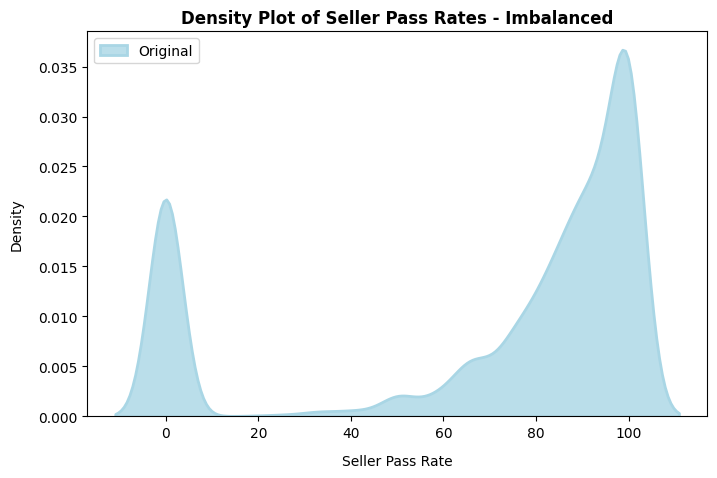

In [49]:
#y_axis_limit = (0, 0.06)  # Adjust based on your data

# Plot the original dataset distribution
plt.figure(figsize=(8, 5))
sns.kdeplot(y_train, fill=True, color='#A9D6E5', label='Original', alpha=0.8, linewidth=2)

# Adjust labels and title for readability
#plt.ylim(y_axis_limit)
plt.xlabel("Seller Pass Rate", labelpad=10)
plt.ylabel("Density", labelpad=10)
#plt.title("Target Variable Density Before RUS", fontsize=16, pad=15)

# Customize ticks for better readability
plt.xticks()
plt.yticks()

# Add a grid for better visual reference
#plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add legend with adjusted font size
plt.legend(loc='upper left')
plt.title("Density Plot of Seller Pass Rates - Imbalanced", fontweight='bold')


# Automatically adjust layout for proper spacing
plt.show()


In [8]:
mean = y_train.mean()
median = y_train.median()
skewness = skew(y_train)
kurt = kurtosis(y_train)

print(f"Mean: {mean}, Median: {median}, Skewness: {skewness}, Kurtosis: {kurt}")


Mean: 70.67713582446936, Median: 88.0, Skewness: -1.1789834991557435, Kurtosis: -0.279010394230613


Training Models

1. Linear Regression

In [9]:
metrics = {} 

In [10]:

# Initialize Linear Regression with default parameters
model = LinearRegression()

# Define MAE as the scoring metric
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Set up 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate the model using cross-validation and calculate fold-wise MAE scores
cv_mae = -cross_val_score(model, X_train, y_train, cv=kf, scoring=mae_scorer, n_jobs=-1)

# Print fold-wise MAE scores
print("Fold-wise MAE scores for Linear Regression:", cv_mae)

# Store fold-wise MAE scores in the metrics dictionary
metrics['Linear Regression'] = cv_mae.tolist()

# Print the metrics dictionary (optional)
print("Updated Metrics Dictionary:", metrics)

# Compute Learning Curve
train_sizes, train_scores, cv_scores = learning_curve(
    estimator=model,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),  # 10 evenly spaced sizes
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=42
)

# Store learning curve data (convert negative MAE to positive)
learning_curve_data = {
    'train_sizes': train_sizes,
    'train_scores_mean': -train_scores.mean(axis=1),
    'train_scores_std': train_scores.std(axis=1),
    'cv_scores_mean': -cv_scores.mean(axis=1),
    'cv_scores_std': cv_scores.std(axis=1)
}

# Print Learning Curve Data Ready message
print("Learning Curve Data Ready")


Fold-wise MAE scores for Linear Regression: [24.7323419  24.90271216 24.9342051  24.86861172 24.62805663]
Updated Metrics Dictionary: {'Linear Regression': [24.732341901035895, 24.90271216462508, 24.934205101179042, 24.868611716984024, 24.628056628643826]}
Learning Curve Data Ready


In [11]:
final_lr_model = LinearRegression()

# Measure training time
start_time = time.time()
final_lr_model.fit(X_train, y_train)
training_time = time.time() - start_time

# Save the trained Random Forest Regressor model
lr_imb_path = "lr_imb.pkl"
dump(final_lr_model, lr_imb_path)
print(f"Linear Regression model saved successfully to {lr_imb_path}!")

# Predict on the training set and evaluate
y_train_pred = final_lr_model.predict(X_train)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))  
train_r2 = r2_score(y_train, y_train_pred)

print("\nTraining Set Results:")
print("MAE:", train_mae)
print("RMSE:", train_rmse)
print("R²:", train_r2)
print("Training Time:", training_time, "seconds")

# Predict on the test set and evaluate
start_time = time.time()
y_pred_lr = final_lr_model.predict(X_test)
test_time = time.time() - start_time

pd.DataFrame(y_pred_lr, columns=["y_pred_lr"]).to_csv("lr_predictions.csv", index=False)


test_mae = mean_absolute_error(y_test, y_pred_lr)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
test_r2 = r2_score(y_test, y_pred_lr)

print("\nTest Set Results:")
print("MAE:", test_mae)
print("RMSE:", test_rmse)
print("R²:", test_r2)
print("Test Evaluation Time:", test_time, "seconds")

Linear Regression model saved successfully to lr_imb.pkl!

Training Set Results:
MAE: 24.803236007321175
RMSE: 31.499756696487133
R²: 0.28396031279335454
Training Time: 0.1278989315032959 seconds

Test Set Results:
MAE: 26.43679455599293
RMSE: 33.4735744356499
R²: 0.19516368612006607
Test Evaluation Time: 0.009278059005737305 seconds


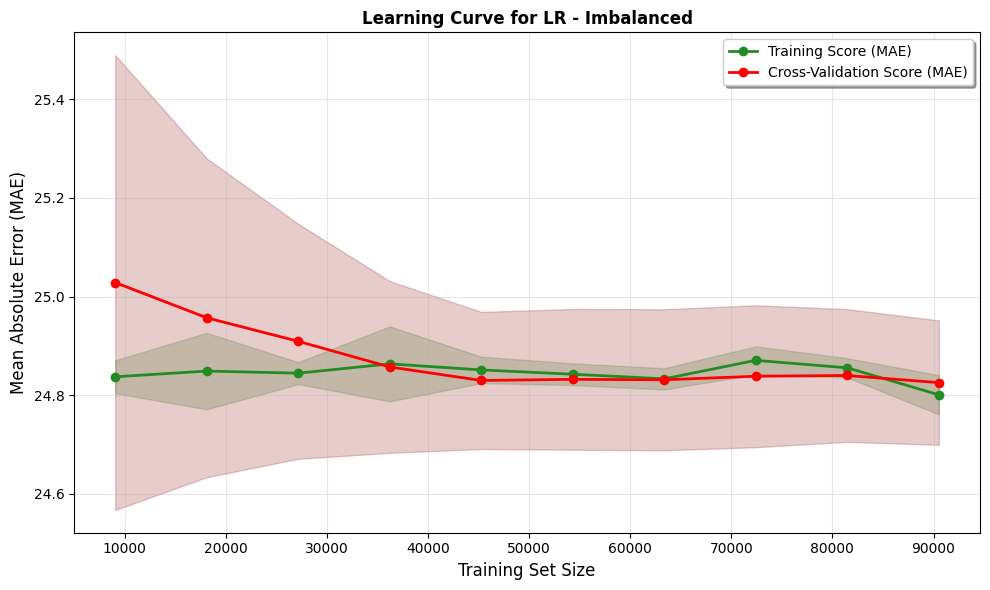

In [14]:
# Plot the learning curve

plt.figure(figsize=(10, 6))

# Plot training scores
plt.plot(
    learning_curve_data['train_sizes'], 
    learning_curve_data['train_scores_mean'], 
    'o-', color='#228B22', label="Training Score (MAE)", linewidth=2, markersize=6
)
plt.fill_between(
    learning_curve_data['train_sizes'],
    learning_curve_data['train_scores_mean'] - learning_curve_data['train_scores_std'],
    learning_curve_data['train_scores_mean'] + learning_curve_data['train_scores_std'],
    alpha=0.2, color='#228B22'
)

# Plot cross-validation scores
plt.plot(
    learning_curve_data['train_sizes'], 
    learning_curve_data['cv_scores_mean'], 
    'o-', color='red', label="Cross-Validation Score (MAE)", linewidth=2, markersize=6
)
plt.fill_between(
    learning_curve_data['train_sizes'],
    learning_curve_data['cv_scores_mean'] - learning_curve_data['cv_scores_std'],
    learning_curve_data['cv_scores_mean'] + learning_curve_data['cv_scores_std'],
    alpha=0.2, color='#8B0000'
)

# Add labels, title, and legend
plt.xlabel("Training Set Size", fontsize=12)
plt.ylabel("Mean Absolute Error (MAE)", fontsize=12)
plt.title("Learning Curve for LR - Imbalanced", fontweight='bold')
plt.legend(loc="best", fontsize=10, frameon=True, shadow=True)
plt.grid(alpha=0.3)

# Improve spacing and add a professional touch
plt.tight_layout()
plt.show()


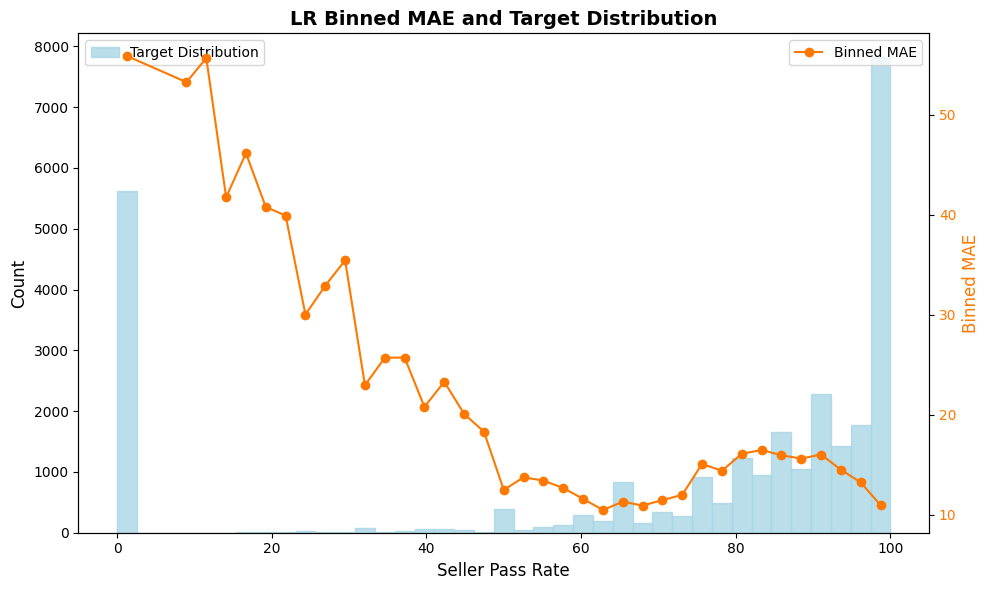

In [15]:
# Target distribution binned MAE for Linear Regression
y_pred = y_pred_lr  # Use predictions from Linear Regression

# Define bins for grouping target values
bins = np.linspace(min(y_test), max(y_test), 40)  # Adjust the number of bins if needed

# Linear Regression Binned MAE Calculation
bin_indices_lr = np.digitize(y_test, bins)  # Create bins for Linear Regression
binned_mae_lr = []
bin_centers_lr = []

for i in range(1, len(bins)):
    mask = bin_indices_lr == i
    if sum(mask) > 0:  # Only calculate MAE for bins with data
        mae = np.mean(np.abs(y_test[mask] - y_pred_lr[mask]))
        binned_mae_lr.append(mae)
        bin_centers_lr.append((bins[i - 1] + bins[i]) / 2)

# Plot Linear Regression Binned MAE
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot histogram for target distribution
ax1.hist(y_test, bins=bins, color="#A9D6E5", alpha=0.8, edgecolor="#A9D6E5", label="Target Distribution")
ax1.set_xlabel("Seller Pass Rate", fontsize=12)
ax1.set_ylabel("Count", fontsize=12, color="black")
ax1.tick_params(axis="y", labelcolor="black")
ax1.set_title("LR Binned MAE and Target Distribution", fontsize=14, fontweight="bold")
ax1.legend(loc="upper left", fontsize=10)

# Add secondary y-axis for Binned MAE
ax2 = ax1.twinx()
ax2.plot(bin_centers_lr, binned_mae_lr, color="#FF7800", marker="o", linestyle="-", label="Binned MAE", linewidth=1.5)
ax2.set_ylabel("Binned MAE", fontsize=12, color="#FF7800")
ax2.tick_params(axis="y", labelcolor="#FF7800")
ax2.legend(loc="upper right", fontsize=10)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


2. Gradient Boosting Regressor

In [16]:

# Automatically extract default hyperparameters for Gradient Boosting Regressor
default_model = GradientBoostingRegressor(random_state=42) 
default_params = default_model.get_params() 

# Filter the default hyperparameters to include only the ones being tuned
tuned_params = ['n_estimators', 'max_depth', 'learning_rate']  
filtered_defaults = {key: default_params[key] for key in tuned_params}

# Print the filtered default hyperparameters
print("Default Hyperparameters (Filtered) for Gradient Boosting Regressor:")
for key, value in filtered_defaults.items():
    print(f"{key}: {value}")

# Define the objective function for Bayesian Optimization
def objective(trial):
    # Define hyperparameters to tune (including defaults as ranges)
    n_estimators = trial.suggest_int('n_estimators', 50, 300, step=10)  # Range with step
    max_depth = trial.suggest_int('max_depth', 2, 20, step=2)  # Integer range
    learning_rate = trial.suggest_float('learning_rate', 0.01, 1.0, step=0.01)  # Continuous range

    # Initialize Gradient Boosting Regressor with suggested hyperparameters
    model = GradientBoostingRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        random_state=42
    )

    # Define MAE as the scoring metric
    mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

    # Set up cross-validation with 5 folds and calculate MAE score
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_mae = cross_val_score(model, X_train, y_train, cv=kf, scoring=mae_scorer, n_jobs=-1)
    return -cv_mae.mean()  # Return negative MAE for minimization

# Run Optuna Bayesian Optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=15)  # Increase trials for final notebook run

# Retrieve the best hyperparameters
best_params = study.best_params
print("Best Parameters from Bayesian Optimization:", best_params)
print("Best Cross-Validation MAE from Bayesian Optimization:", study.best_value)

# Evaluate the best model and store fold-wise MAE scores
final_model = GradientBoostingRegressor(**best_params, random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Collect fold-wise MAE scores
cv_mae = -cross_val_score(final_model, X_train, y_train, cv=kf, scoring=mae_scorer, n_jobs=-1)

# Add results to the metrics dictionary
metrics['Gradient Boosting'] = cv_mae.tolist()

# Print fold-wise scores (optional)
print("Fold-wise MAE scores for Gradient Boosting Regressor:", cv_mae)

# Compute Learning Curve
train_sizes, train_scores, cv_scores = learning_curve(
    estimator=final_model,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),  # 10 evenly spaced sizes
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=42
)

# Store learning curve data (convert negative MAE to positive)
learning_curve_data = {
    'train_sizes': train_sizes,
    'train_scores_mean': -train_scores.mean(axis=1),
    'train_scores_std': train_scores.std(axis=1),
    'cv_scores_mean': -cv_scores.mean(axis=1),
    'cv_scores_std': cv_scores.std(axis=1)
}

# Print the metrics dictionary to verify
print("Updated Metrics Dictionary:", metrics)
print("Learning Curve Data Ready")


[I 2024-11-28 00:09:41,331] A new study created in memory with name: no-name-cc966cbe-b230-487c-b24e-d89f1ef02eb8


Default Hyperparameters (Filtered) for Gradient Boosting Regressor:
n_estimators: 100
max_depth: 3
learning_rate: 0.1


[I 2024-11-28 00:23:31,664] Trial 0 finished with value: 17.997487997738574 and parameters: {'n_estimators': 300, 'max_depth': 12, 'learning_rate': 0.81}. Best is trial 0 with value: 17.997487997738574.
[I 2024-11-28 00:24:05,564] Trial 1 finished with value: 17.714675601812477 and parameters: {'n_estimators': 70, 'max_depth': 2, 'learning_rate': 0.02}. Best is trial 1 with value: 17.714675601812477.
[I 2024-11-28 00:30:04,316] Trial 2 finished with value: 13.584647495347578 and parameters: {'n_estimators': 100, 'max_depth': 16, 'learning_rate': 0.22}. Best is trial 2 with value: 13.584647495347578.
[I 2024-11-28 00:41:27,847] Trial 3 finished with value: 14.919433863821292 and parameters: {'n_estimators': 190, 'max_depth': 16, 'learning_rate': 0.45}. Best is trial 2 with value: 13.584647495347578.
[I 2024-11-28 00:57:52,881] Trial 4 finished with value: 15.97379586903665 and parameters: {'n_estimators': 260, 'max_depth': 18, 'learning_rate': 0.65}. Best is trial 2 with value: 13.58464

Best Parameters from Bayesian Optimization: {'n_estimators': 50, 'max_depth': 6, 'learning_rate': 0.35000000000000003}
Best Cross-Validation MAE from Bayesian Optimization: 12.380685729992114
Fold-wise MAE scores for Gradient Boosting Regressor: [12.4465525  12.44228042 12.41435959 12.24553857 12.35469758]
Updated Metrics Dictionary: {'Linear Regression': [24.732341901035895, 24.90271216462508, 24.934205101179042, 24.868611716984024, 24.628056628643826], 'Gradient Boosting': [12.446552497129094, 12.442280418583007, 12.414359585274404, 12.24553857391973, 12.35469757505434]}
Learning Curve Data Ready


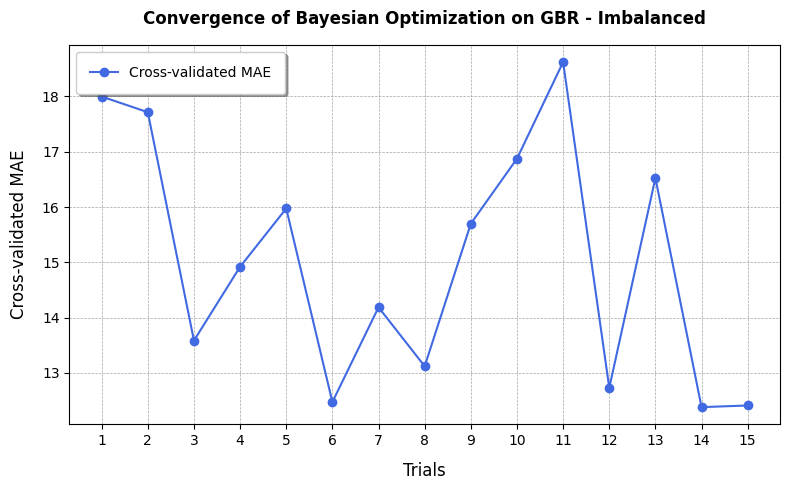

In [17]:
# Convergence Plot 


plt.figure(figsize=(8, 5))  # Slightly larger figure for better readability

# Extract data from trials
trials = study.trials_dataframe()
plt.plot(
    trials.index, 
    trials['value'], 
    marker='o', 
    linestyle='-', 
    color='#4169e1',  # Subtle blue color for the line
    label='Cross-validated MAE'
)

# Adding labels and title
plt.xlabel('Trials', fontsize=12, labelpad=10)  # Add padding for better spacing
plt.ylabel('Cross-validated MAE', fontsize=12, labelpad=10)
plt.title('Convergence of Bayesian Optimization on GBR - Imbalanced', fontsize=12, pad=15, fontweight="bold")

# Ensure Trial Index is displayed as integers
plt.xticks(ticks=range(len(trials)), labels=range(1, len(trials) + 1))  # Trial indices start from 1

# Grid for better readability
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# Adding a legend
plt.legend(fontsize=10, loc='best', frameon=True, shadow=True, borderpad=1)

# Improve layout and show the plot
plt.tight_layout()
plt.show()


In [18]:
# Training and Testing with the Best Hyperparameters
best_params = study.best_params

# Initialize Gradient Boosting Regressor with the best parameters
final_gbr_model = GradientBoostingRegressor(**best_params, random_state=42)

# Measure training time
start_time = time.time()
final_gbr_model.fit(X_train, y_train)
training_time = time.time() - start_time

# Save the trained Random Forest Regressor model
gbr_imb_path = "gbr_imb.pkl"
dump(final_gbr_model, gbr_imb_path)
print(f"Gradient Boosting model saved successfully to {gbr_imb_path}!")

# Predict on the training set and evaluate
y_train_pred = final_gbr_model.predict(X_train)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))  # Root Mean Squared Error
train_r2 = r2_score(y_train, y_train_pred)

print("\nTraining Set Results with Best Parameters:")
print("MAE:", train_mae)
print("RMSE:", train_rmse)
print("R²:", train_r2)
print("Training Time:", training_time, "seconds")

# Predict on the test set and evaluate
start_time = time.time()
y_pred_gbr = final_gbr_model.predict(X_test)
test_time = time.time() - start_time

pd.DataFrame(y_pred_gbr, columns=["y_pred_gbr"]).to_csv("gbr_predictions.csv", index=False)


test_mae = mean_absolute_error(y_test, y_pred_gbr)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_gbr))
test_r2 = r2_score(y_test, y_pred_gbr)

print("\nTest Set Results with Best Parameters:")
print("MAE:", test_mae)
print("RMSE:", test_rmse)
print("R²:", test_r2)
print("Test Evaluation Time:", test_time, "seconds")


Gradient Boosting model saved successfully to gbr_imb.pkl!

Training Set Results with Best Parameters:
MAE: 11.679225318398089
RMSE: 19.60613549143262
R²: 0.7225998480128963
Training Time: 64.12012219429016 seconds

Test Set Results with Best Parameters:
MAE: 13.72888503372887
RMSE: 23.302560764266183
R²: 0.6099586232822474
Test Evaluation Time: 0.09389209747314453 seconds


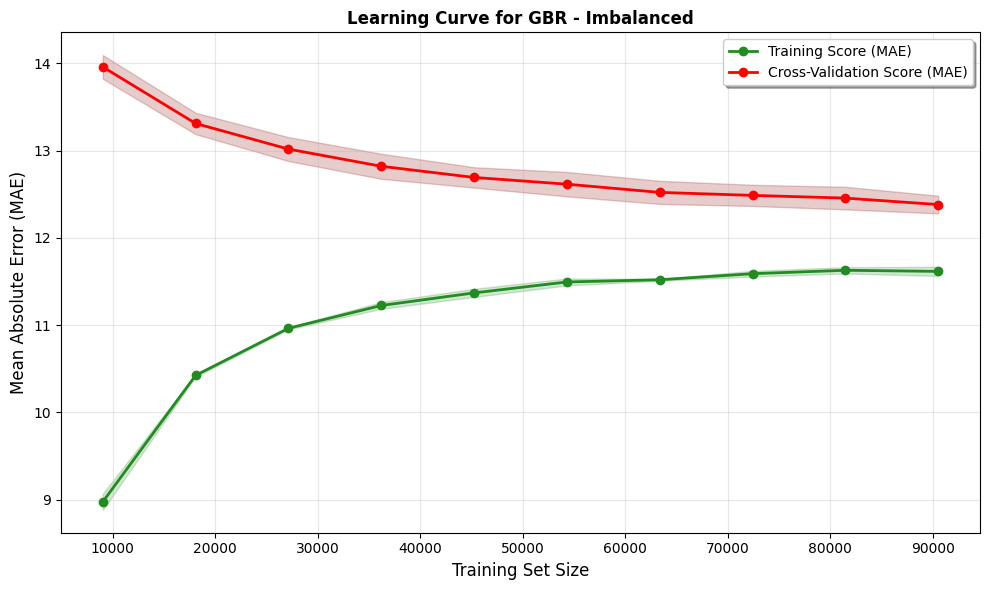

In [19]:
# Plot the learning curve

plt.figure(figsize=(10, 6))

# Plot training scores
plt.plot(
    learning_curve_data['train_sizes'], 
    learning_curve_data['train_scores_mean'], 
    'o-', color='#228B22', label="Training Score (MAE)", linewidth=2, markersize=6
)
plt.fill_between(
    learning_curve_data['train_sizes'],
    learning_curve_data['train_scores_mean'] - learning_curve_data['train_scores_std'],
    learning_curve_data['train_scores_mean'] + learning_curve_data['train_scores_std'],
    alpha=0.2, color='#228B22'
)

# Plot cross-validation scores
plt.plot(
    learning_curve_data['train_sizes'], 
    learning_curve_data['cv_scores_mean'], 
    'o-', color='red', label="Cross-Validation Score (MAE)", linewidth=2, markersize=6
)
plt.fill_between(
    learning_curve_data['train_sizes'],
    learning_curve_data['cv_scores_mean'] - learning_curve_data['cv_scores_std'],
    learning_curve_data['cv_scores_mean'] + learning_curve_data['cv_scores_std'],
    alpha=0.2, color='#8B0000'
)

# Add labels, title, and legend
plt.xlabel("Training Set Size", fontsize=12)
plt.ylabel("Mean Absolute Error (MAE)", fontsize=12)
plt.title("Learning Curve for GBR - Imbalanced", fontweight='bold')
plt.legend(loc="best", fontsize=10, frameon=True, shadow=True)
plt.grid(alpha=0.3)

# Improve spacing and add a professional touch
plt.tight_layout()
plt.show()


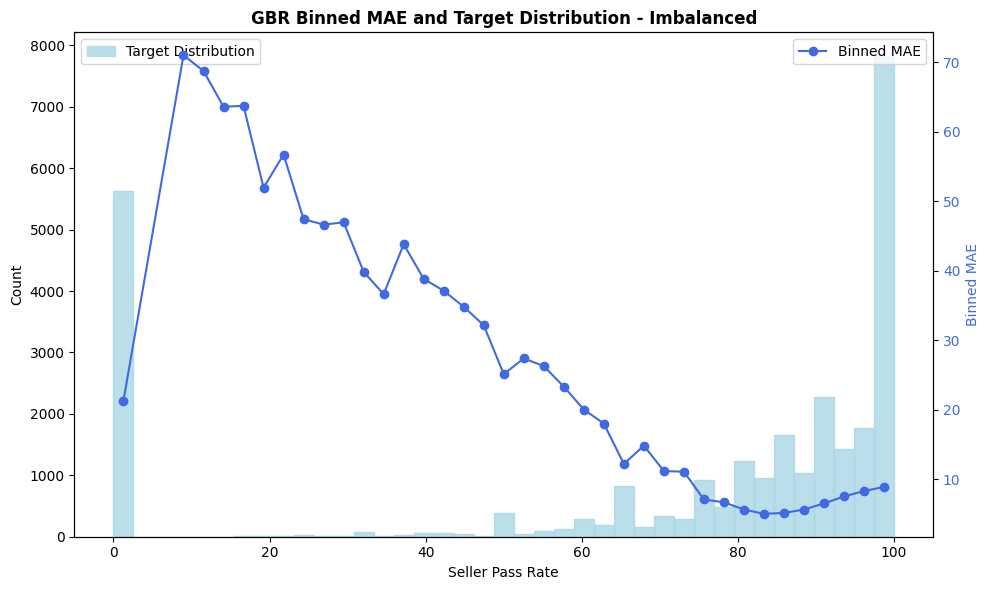

In [20]:
# target distribution binned mae

y_pred = y_pred_gbr 

# Define bins for grouping target values
bins = np.linspace(min(y_test), max(y_test), 40)

# GBR Binned MAE Calculation
bin_indices_gbr = np.digitize(y_test, bins)  # Create bins for GBR
binned_mae_gbr = []
bin_centers_gbr = []

for i in range(1, len(bins)):
    mask = bin_indices_gbr == i
    if sum(mask) > 0:
        mae = np.mean(np.abs(y_test[mask] - y_pred_gbr[mask]))
        binned_mae_gbr.append(mae)
        bin_centers_gbr.append((bins[i - 1] + bins[i]) / 2)

# Plot GBR Binned MAE
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.hist(y_test, bins=bins, color="#A9D6E5", alpha=0.8, edgecolor="#A9D6E5", label="Target Distribution")
ax1.set_xlabel("Seller Pass Rate")
ax1.set_ylabel("Count")
ax1.tick_params(axis="y", labelcolor="black")
ax1.set_title("GBR Binned MAE and Target Distribution - Imbalanced", fontweight="bold")
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
ax2.plot(bin_centers_gbr, binned_mae_gbr, color="#4169e1", marker="o", linestyle="-", label="Binned MAE")
ax2.set_ylabel("Binned MAE", color="#4169e1")
ax2.tick_params(axis="y", labelcolor="#4169e1")
ax2.legend(loc="upper right")
plt.tight_layout()
plt.show()   



3. Random Forest Regressor

In [21]:
# Automatically extract default hyperparameters for Random Forest Regressor
default_model = RandomForestRegressor(random_state=42)  
default_params = default_model.get_params()  

# Filter the default hyperparameters to include only the ones being tuned
tuned_params = ['n_estimators', 'max_depth', 'max_features']  
filtered_defaults = {key: default_params[key] for key in tuned_params}

# Print the filtered default hyperparameters
print("Default Hyperparameters (Filtered) for Random Forest Regressor:")
for key, value in filtered_defaults.items():
    print(f"{key}: {value}")

# Define the objective function for Bayesian Optimization
def objective(trial):
    # Define hyperparameters to tune (including defaults as ranges)
    n_estimators = trial.suggest_int('n_estimators', 50, 300, step=10)  # Range with step
    max_depth = trial.suggest_int('max_depth', 2, 20, step=2)  # Integer range
    max_features = trial.suggest_float('max_features', 0.1, 1.0)  # Continuous range

    # Initialize Random Forest Regressor with suggested hyperparameters
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_features=max_features,
        random_state=42
    )

    # Define MAE as the scoring metric
    mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

    # Set up cross-validation with 5 folds and calculate MAE score
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_mae = cross_val_score(model, X_train, y_train, cv=kf, scoring=mae_scorer, n_jobs=-1)
    return -cv_mae.mean()  # Return negative MAE for minimization

# Run Optuna Bayesian Optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=15)  # 15 trials

# Retrieve the best hyperparameters
best_params = study.best_params
print("Best Parameters from Bayesian Optimization:", best_params)
print("Best Cross-Validation MAE from Bayesian Optimization:", study.best_value)

# Evaluate the best model and store fold-wise MAE scores
final_model = RandomForestRegressor(**best_params, random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Collect fold-wise MAE scores
cv_mae = -cross_val_score(final_model, X_train, y_train, cv=kf, scoring=mae_scorer, n_jobs=-1)

# Add results to the metrics dictionary
metrics['Random Forest'] = cv_mae.tolist()

# Print fold-wise scores (optional)
print("Fold-wise MAE scores for Random Forest Regressor:", cv_mae)

# Compute Learning Curve
train_sizes, train_scores, cv_scores = learning_curve(
    estimator=final_model,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),  # 10 evenly spaced sizes
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=42
)

# Store learning curve data (convert negative MAE to positive)
learning_curve_data = {
    'train_sizes': train_sizes,
    'train_scores_mean': -train_scores.mean(axis=1),
    'train_scores_std': train_scores.std(axis=1),
    'cv_scores_mean': -cv_scores.mean(axis=1),
    'cv_scores_std': cv_scores.std(axis=1)
}

# Print the metrics dictionary to verify
print("Updated Metrics Dictionary:", metrics)
print("Learning Curve Data Ready")


[I 2024-11-28 01:49:27,585] A new study created in memory with name: no-name-4f469e78-00a6-4bde-8954-a254bc9dcd08


Default Hyperparameters (Filtered) for Random Forest Regressor:
n_estimators: 100
max_depth: None
max_features: 1.0


[I 2024-11-28 01:49:46,585] Trial 0 finished with value: 14.829922190205844 and parameters: {'n_estimators': 90, 'max_depth': 8, 'max_features': 0.17865246374907473}. Best is trial 0 with value: 14.829922190205844.
[I 2024-11-28 01:50:01,551] Trial 1 finished with value: 13.950415636865168 and parameters: {'n_estimators': 50, 'max_depth': 16, 'max_features': 0.12492070661648971}. Best is trial 1 with value: 13.950415636865168.
[I 2024-11-28 01:56:38,140] Trial 2 finished with value: 11.977277775718676 and parameters: {'n_estimators': 240, 'max_depth': 16, 'max_features': 0.8823697187207277}. Best is trial 2 with value: 11.977277775718676.
[I 2024-11-28 01:57:40,789] Trial 3 finished with value: 12.274441883576563 and parameters: {'n_estimators': 160, 'max_depth': 20, 'max_features': 0.2802096665721372}. Best is trial 2 with value: 11.977277775718676.
[I 2024-11-28 01:57:47,402] Trial 4 finished with value: 19.290521473895545 and parameters: {'n_estimators': 100, 'max_depth': 2, 'max_fe

Best Parameters from Bayesian Optimization: {'n_estimators': 240, 'max_depth': 16, 'max_features': 0.8823697187207277}
Best Cross-Validation MAE from Bayesian Optimization: 11.977277775718676
Fold-wise MAE scores for Random Forest Regressor: [12.04993761 11.99352861 12.03471606 11.84528735 11.96291925]
Updated Metrics Dictionary: {'Linear Regression': [24.732341901035895, 24.90271216462508, 24.934205101179042, 24.868611716984024, 24.628056628643826], 'Gradient Boosting': [12.446552497129094, 12.442280418583007, 12.414359585274404, 12.24553857391973, 12.35469757505434], 'Random Forest': [12.049937606460388, 11.993528608990431, 12.034716062366565, 11.84528734838512, 11.962919252390874]}
Learning Curve Data Ready


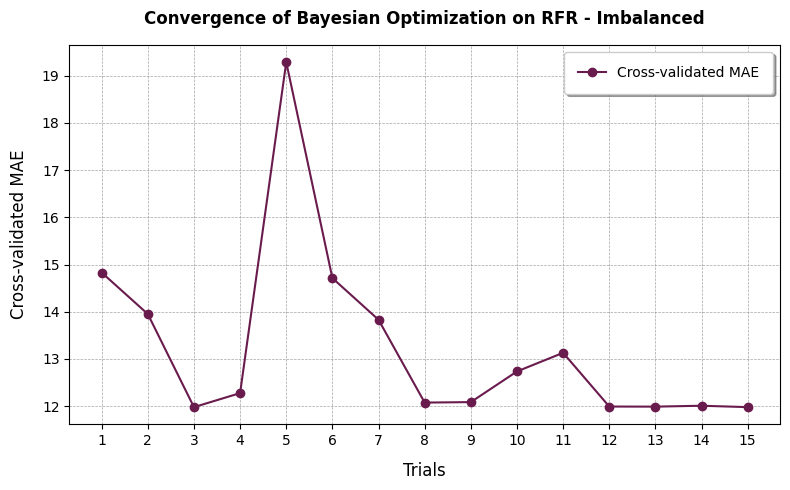

In [22]:
# Convergence Plot 


plt.figure(figsize=(8, 5))  

# Extract data from trials
trials = study.trials_dataframe()
plt.plot(
    trials.index, 
    trials['value'], 
    marker='o', 
    linestyle='-', 
    color='#6A1B4D', #burgundy
    label='Cross-validated MAE'
)

# Adding labels and title
plt.xlabel('Trials', fontsize=12, labelpad=10)  # Add padding for better spacing
plt.ylabel('Cross-validated MAE', fontsize=12, labelpad=10)
plt.title('Convergence of Bayesian Optimization on RFR - Imbalanced', fontsize=12, pad=15, fontweight="bold")

# Ensure Trial Index is displayed as integers
plt.xticks(ticks=range(len(trials)), labels=range(1, len(trials) + 1))  # Trial indices start from 1

# Grid for better readability
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# Adding a legend
plt.legend(fontsize=10, loc='best', frameon=True, shadow=True, borderpad=1)

# Improve layout and show the plot
plt.tight_layout()
plt.show()


In [23]:

# Initialize Random Forest Regressor with the best parameters
final_rfr_model = RandomForestRegressor(**best_params, random_state=42)

# Measure training time
start_time = time.time()
final_rfr_model.fit(X_train, y_train)
training_time = time.time() - start_time

# Save the trained Random Forest Regressor model
rfr_imb_path = "rfr_imb.pkl"
dump(final_rfr_model, rfr_imb_path)
print(f"Random Forest model saved successfully to {rfr_imb_path}!")

# to load the model (if needed)
# loaded_model = load(model_path)
# print("Model loaded successfully!")

# Predict on the training set and evaluate
y_train_pred = final_rfr_model.predict(X_train)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred)) 
train_r2 = r2_score(y_train, y_train_pred)

print("\nTraining Set Results with Best Parameters:")
print("MAE:", train_mae)
print("RMSE:", train_rmse)
print("R²:", train_r2)
print("Training Time:", training_time, "seconds")

# Predict on the test set and evaluate
start_time = time.time()
y_pred_rfr = final_rfr_model.predict(X_test)
test_time = time.time() - start_time

pd.DataFrame(y_pred_rfr, columns=["y_pred_rfr"]).to_csv("rfr_predictions.csv", index=False) #saving rfr predicitons for ttest later

test_mae = mean_absolute_error(y_test, y_pred_rfr)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rfr))
test_r2 = r2_score(y_test, y_pred_rfr)

print("\nTest Set Results with Best Parameters:")
print("MAE:", test_mae)
print("RMSE:", test_rmse)
print("R²:", test_r2)
print("Test Evaluation Time:", test_time, "seconds")


Random Forest model saved successfully to rfr_imb.pkl!

Training Set Results with Best Parameters:
MAE: 10.864426926728886
RMSE: 18.612628746459773
R²: 0.7500010841874392
Training Time: 298.55572986602783 seconds

Test Set Results with Best Parameters:
MAE: 13.287579646900893
RMSE: 22.8823569344281
R²: 0.623898648610066
Test Evaluation Time: 0.870311975479126 seconds


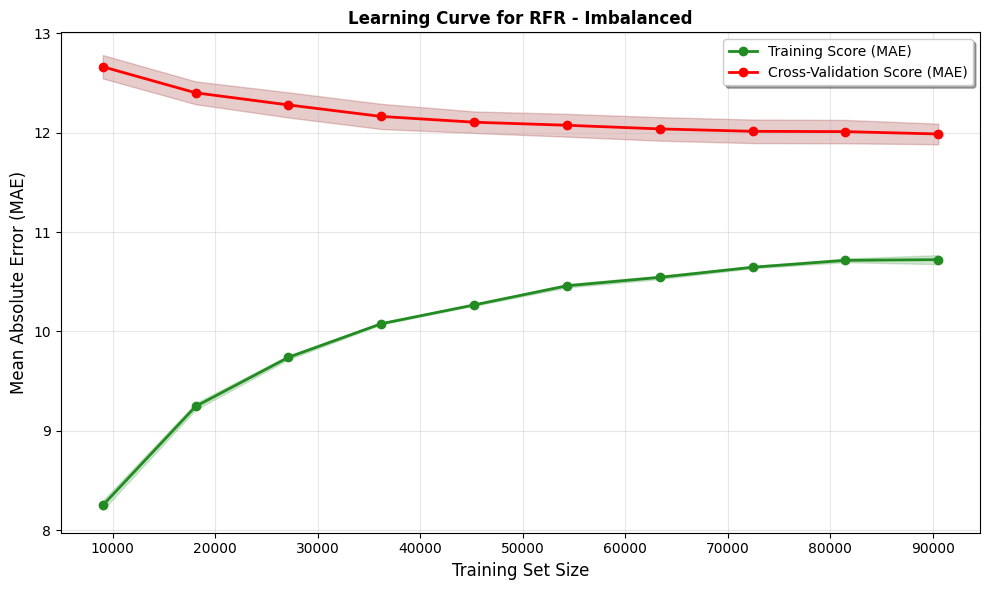

In [24]:
# Plot the learning curve

plt.figure(figsize=(10, 6))

# Plot training scores
plt.plot(
    learning_curve_data['train_sizes'], 
    learning_curve_data['train_scores_mean'], 
    'o-', color='#228B22', label="Training Score (MAE)", linewidth=2, markersize=6
)
plt.fill_between(
    learning_curve_data['train_sizes'],
    learning_curve_data['train_scores_mean'] - learning_curve_data['train_scores_std'],
    learning_curve_data['train_scores_mean'] + learning_curve_data['train_scores_std'],
    alpha=0.2, color='#228B22'
)

# Plot cross-validation scores
plt.plot(
    learning_curve_data['train_sizes'], 
    learning_curve_data['cv_scores_mean'], 
    'o-', color='red', label="Cross-Validation Score (MAE)", linewidth=2, markersize=6
)
plt.fill_between(
    learning_curve_data['train_sizes'],
    learning_curve_data['cv_scores_mean'] - learning_curve_data['cv_scores_std'],
    learning_curve_data['cv_scores_mean'] + learning_curve_data['cv_scores_std'],
    alpha=0.2, color='#8B0000'
)

# Add labels, title, and legend
plt.xlabel("Training Set Size", fontsize=12)
plt.ylabel("Mean Absolute Error (MAE)", fontsize=12)
plt.title("Learning Curve for RFR - Imbalanced", fontweight='bold')
plt.legend(loc="best", fontsize=10, frameon=True, shadow=True)
plt.grid(alpha=0.3)

# Improve spacing and add a professional touch
plt.tight_layout()
plt.show()


Binned MAE for GBR: [21.28382939742943, 71.01644024142838, 68.75705416154283, 63.60303027153291, 63.73611007411392, 51.94292239086891, 56.7267434945907, 47.412121597038684, 46.63128467418021, 46.964593019659596, 39.83939848084683, 36.61865615723343, 43.80312727824877, 38.82580945150225, 37.11294121931718, 34.80334761819446, 32.154257656794655, 25.098317252870217, 27.37290197587539, 26.268998207003843, 23.307549149810207, 20.00462613671761, 17.995008899983457, 12.177973283966805, 14.805664945313328, 11.155807593304752, 11.061975740043557, 7.063866842194258, 6.650616368772767, 5.617110386974195, 4.999933836725417, 5.123094023347469, 5.613564219517009, 6.493201943374775, 7.494962851017671, 8.283611050350146, 8.86678418732477]
Binned MAE for RFR: [19.991619325955025, 69.23453971367844, 67.51465707779131, 64.78242102943616, 62.17195348897344, 51.04630352844557, 56.620831745661334, 48.133249238641724, 48.2034154626933, 47.593401744765664, 40.744341215917764, 35.44654926674377, 43.02716667005

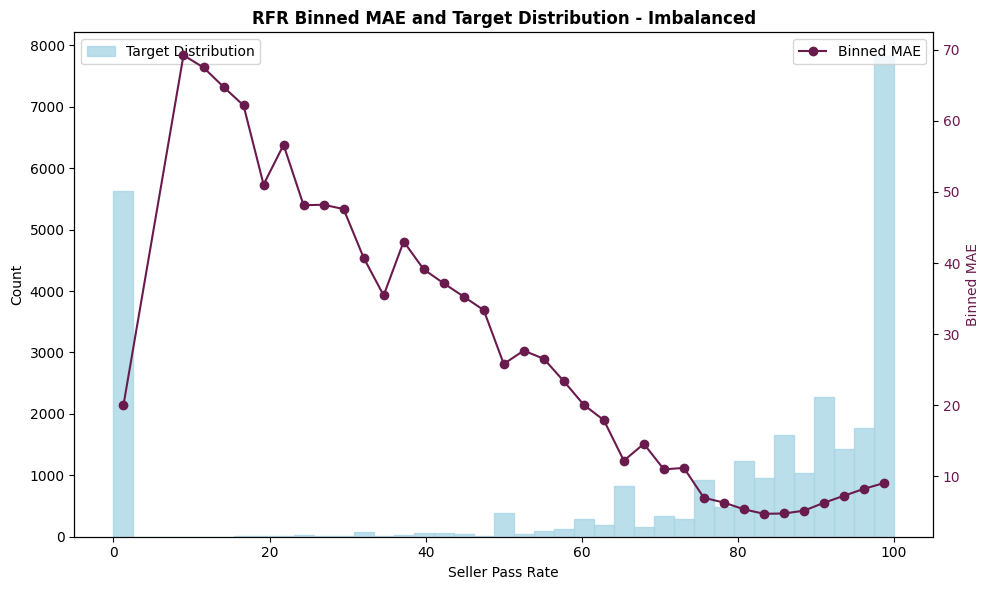

In [25]:
# target distribution binned mae

y_pred = y_pred_rfr 

# RFR Binned MAE Calculation
bin_indices_rfr = np.digitize(y_test, bins)  # Create bins for RFR
binned_mae_rfr = []
bin_centers_rfr = []

for i in range(1, len(bins)):
    mask = bin_indices_rfr == i
    if sum(mask) > 0:
        mae = np.mean(np.abs(y_test[mask] - y_pred_rfr[mask]))
        binned_mae_rfr.append(mae)
        bin_centers_rfr.append((bins[i - 1] + bins[i]) / 2)

# Print to Verify Results
print("Binned MAE for GBR:", binned_mae_gbr)
print("Binned MAE for RFR:", binned_mae_rfr)

# Plot RFR Binned MAE
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.hist(y_test, bins=bins, color="#A9D6E5", alpha=0.8, edgecolor="#A9D6E5", label="Target Distribution")
ax1.set_xlabel("Seller Pass Rate")
ax1.set_ylabel("Count")
ax1.tick_params(axis="y", labelcolor="black", )
ax1.set_title("RFR Binned MAE and Target Distribution - Imbalanced", fontweight="bold")
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
ax2.plot(bin_centers_rfr, binned_mae_rfr, color="#6A1B4D", marker="o", linestyle="-", label="Binned MAE")
ax2.set_ylabel("Binned MAE", color="#6A1B4D")
ax2.tick_params(axis="y", labelcolor="#6A1B4D")
ax2.legend(loc="upper right")
plt.tight_layout()
plt.show()



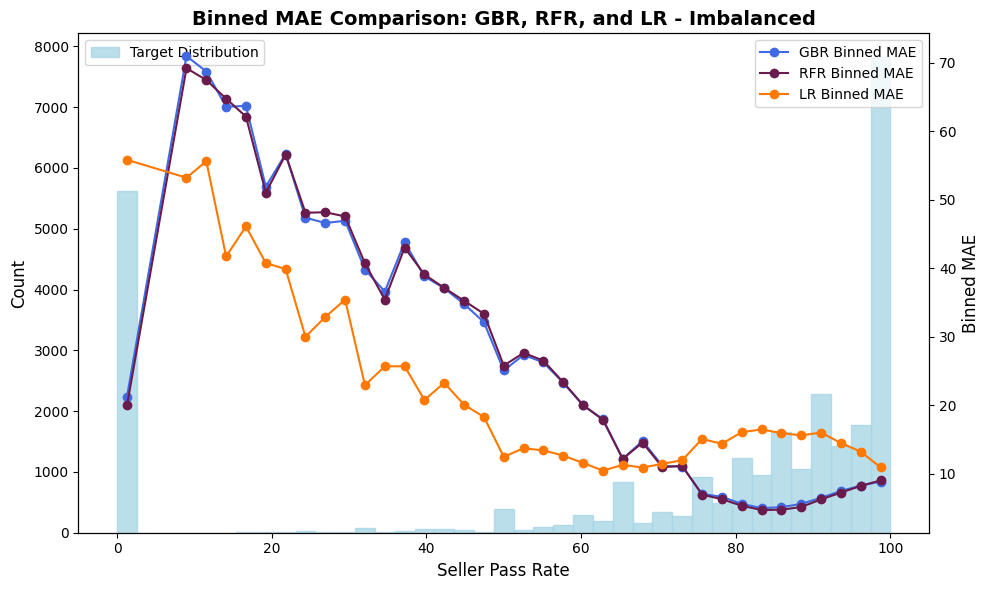

In [26]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot histogram for target distribution
ax1.hist(y_test, bins=bins, color="#A9D6E5", alpha=0.8, edgecolor="#A9D6E5", label="Target Distribution")
ax1.set_xlabel("Seller Pass Rate", fontsize=12)
ax1.set_ylabel("Count", fontsize=12, color="black")
ax1.tick_params(axis="y", labelcolor="black")
ax1.legend(loc="upper left", fontsize=10)

# Add secondary y-axis for Binned MAE
ax2 = ax1.twinx()

# Plot GBR Binned MAE
ax2.plot(bin_centers_gbr, binned_mae_gbr, color="#4169e1", marker="o", linestyle="-", label="GBR Binned MAE", linewidth=1.5)

# Plot RFR Binned MAE
ax2.plot(bin_centers_rfr, binned_mae_rfr, color="#6A1B4D", marker="o", linestyle="-", label="RFR Binned MAE", linewidth=1.5)

# Plot LR Binned MAE
ax2.plot(bin_centers_lr, binned_mae_lr, color="#FF7800", marker="o", linestyle="-", label="LR Binned MAE", linewidth=1.5)

# Set secondary y-axis properties
ax2.set_ylabel("Binned MAE", fontsize=12, color="black")
ax2.tick_params(axis="y", labelcolor="black")
ax2.legend(loc="upper right", fontsize=10)

# Title
plt.title("Binned MAE Comparison: GBR, RFR, and LR - Imbalanced", fontsize=14, fontweight="bold")

# Adjust layout and show plot
plt.tight_layout()
plt.show()


Feature Importance and Insights

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns 

def plot_feature_importance(model, feature_names, model_name, top_n=10):
    """
    Plots the feature importance for a given model.
    
    Parameters:
    - model: Trained model (GBR or RFR)
    - feature_names: List of feature names
    - model_name: Name of the model (string)
    - top_n: Number of top features to display
    """
    # Extract feature importances
    importances = model.feature_importances_
    
    # Create a DataFrame for sorting and visualization
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False).head(top_n)
    
      # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=feature_importance_df, 
        x='Importance', 
        y='Feature', 
        color="#01386A", 
        linewidth=1,  # Reduces overall bar size visually
        dodge=False  # Ensures no overlapping
    )
    plt.title(f"Top {top_n} Most Predictive Features: {model_name}", fontweight="bold")
    plt.xlabel("Feature Importance")
    plt.ylabel("Features")
    plt.tight_layout()
    plt.show()


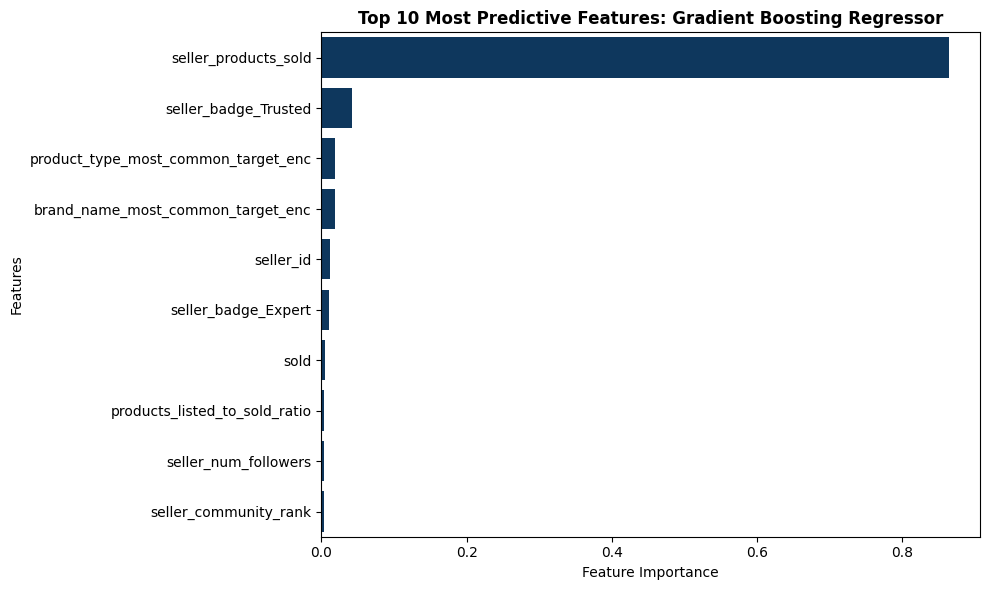

In [32]:
# Plot for GBR
plot_feature_importance(final_gbr_model, X_train.columns, "Gradient Boosting Regressor")

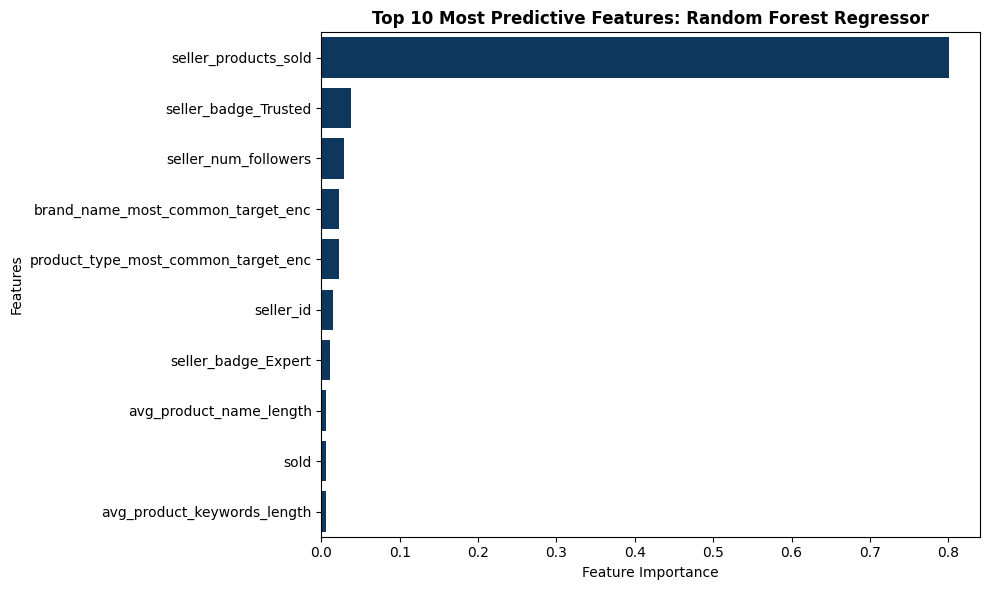

In [33]:
# Plot for RFR
plot_feature_importance(final_rfr_model, X_train.columns, "Random Forest Regressor")

In [34]:
# Load the mapping file
seller_country_mapping = pd.read_csv('seller_country_mapping.csv')

# Ensure y_train is a DataFrame and reset index for alignment
y_train_reset = y_train.reset_index(drop=True)

# Merge mapping back with the encoded dataset
X_train_with_countries = pd.merge(
    X_train[['seller_country_target_enc']].reset_index(drop=True),  # Encoded data with index reset
    seller_country_mapping,  # Mapping file
    on='seller_country_target_enc',
    how='left'  # Match encoded values
)

# Add the target variable back to the merged dataset
X_train_with_countries['seller_pass_rate'] = y_train_reset


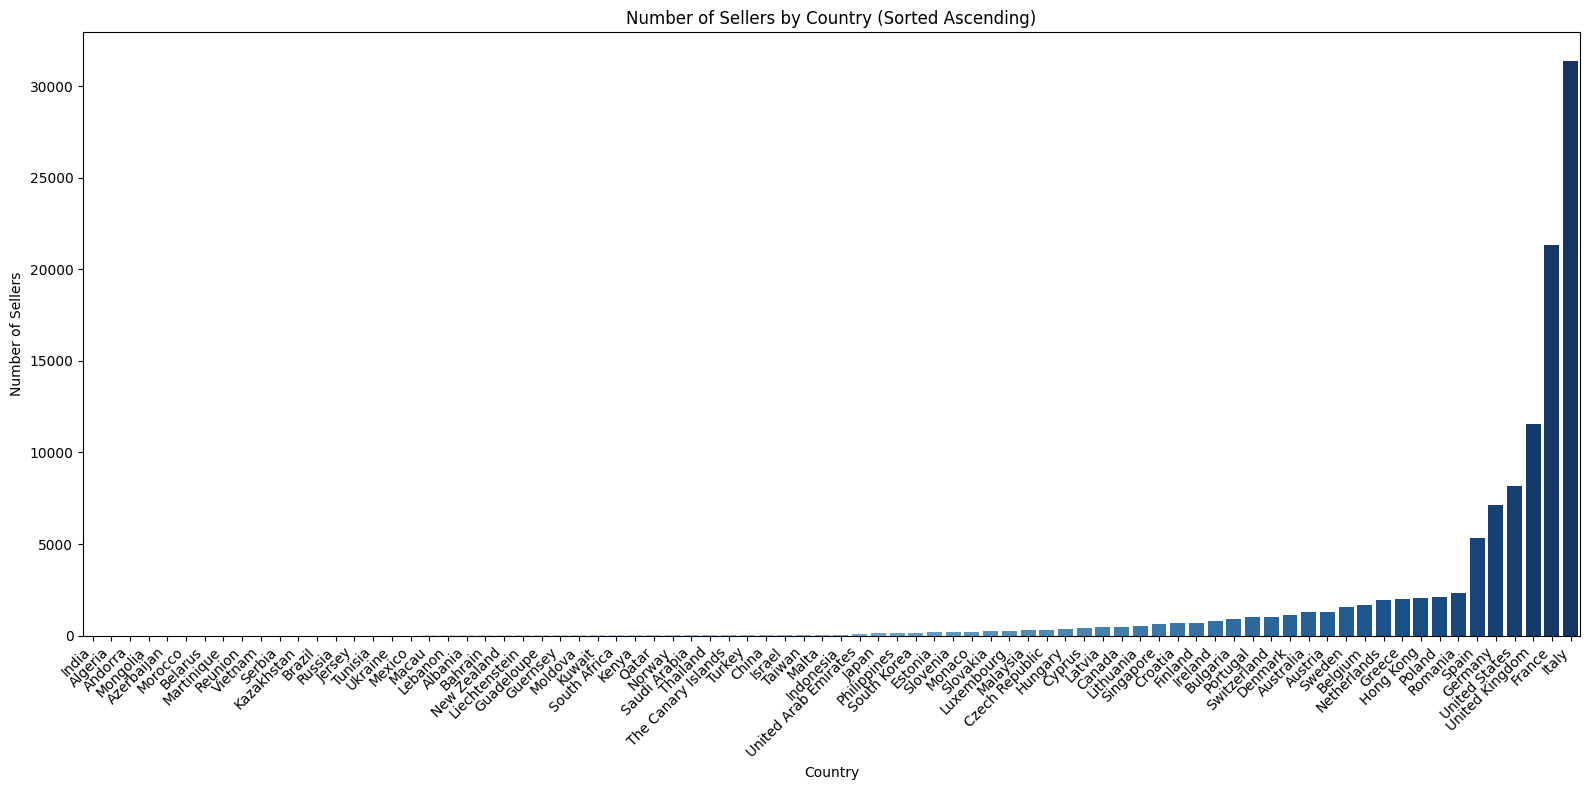

In [36]:
# Group by country names and count the number of sellers
num_sellers_by_country = (
    X_train_with_countries.groupby('seller_country')['seller_pass_rate']
    .count()
    .reset_index()
    .rename(columns={'seller_pass_rate': 'num_sellers'})
)

# Sort by the number of sellers in ascending order
num_sellers_by_country = num_sellers_by_country.sort_values(by='num_sellers', ascending=True)

# Plot the number of sellers per country
plt.figure(figsize=(16, 8))
sns.barplot(
    data=num_sellers_by_country,
    x='seller_country',
    y='num_sellers',
    palette="Blues"
)

plt.title("Number of Sellers by Country (Sorted Ascending)")
plt.xlabel("Country")
plt.ylabel("Number of Sellers")
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.show()



Error Analysis

LR

/var/folders/py/w8w96dx57h53hf_ggjt2zdxh0000gn/T/ipykernel_1208/3696284067.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red', linewidth=2)  # Diagonal line


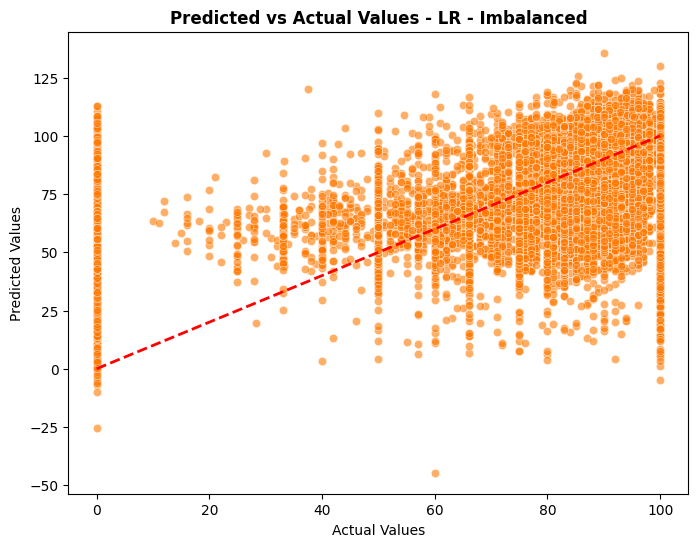

In [37]:
# Prediction vs Actual plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_lr, alpha=0.6, color='#FF7800')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red', linewidth=2)  # Diagonal line
plt.title("Predicted vs Actual Values - LR - Imbalanced", fontweight="bold")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()


GBR

/var/folders/py/w8w96dx57h53hf_ggjt2zdxh0000gn/T/ipykernel_1208/2387774861.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red', linewidth=2)  # Diagonal line


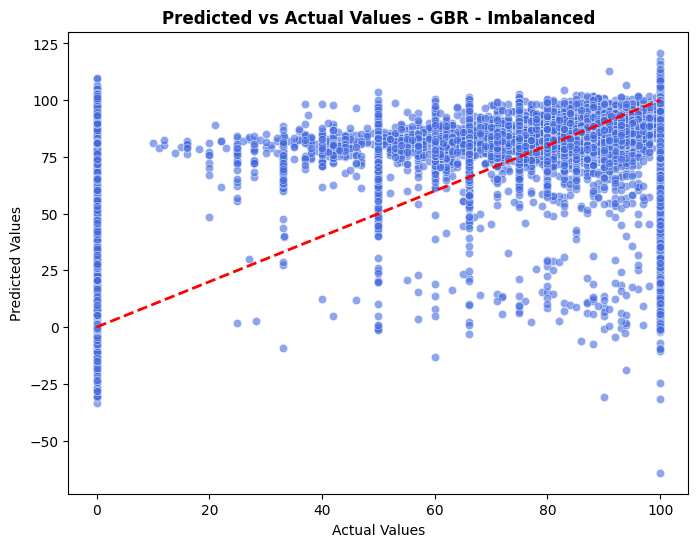

In [38]:
# Prediction vs Actual plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_gbr, alpha=0.6, color='#4169e1') 
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red', linewidth=2)  # Diagonal line
plt.title("Predicted vs Actual Values - GBR - Imbalanced", fontweight="bold")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()

RFR

/var/folders/py/w8w96dx57h53hf_ggjt2zdxh0000gn/T/ipykernel_1208/3873076489.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red', linewidth=2)  # Diagonal line


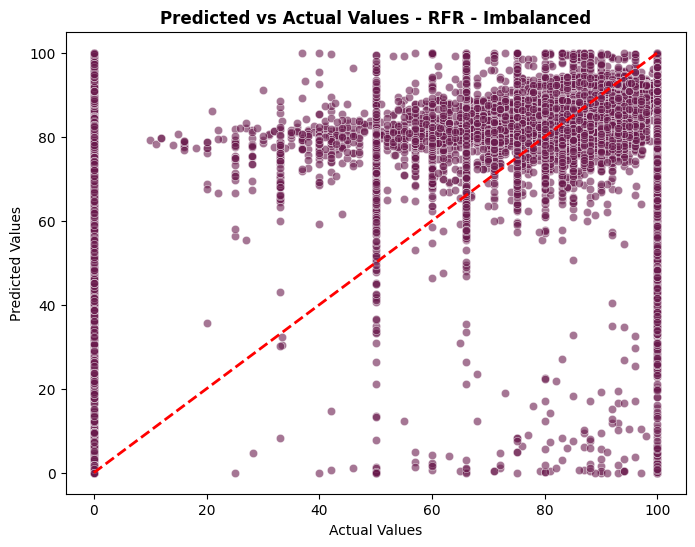

In [39]:
# Prediction vs Actual plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_rfr, alpha=0.6, color='#6A1B4D')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red', linewidth=2)  # Diagonal line
plt.title("Predicted vs Actual Values - RFR - Imbalanced", fontweight="bold")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()

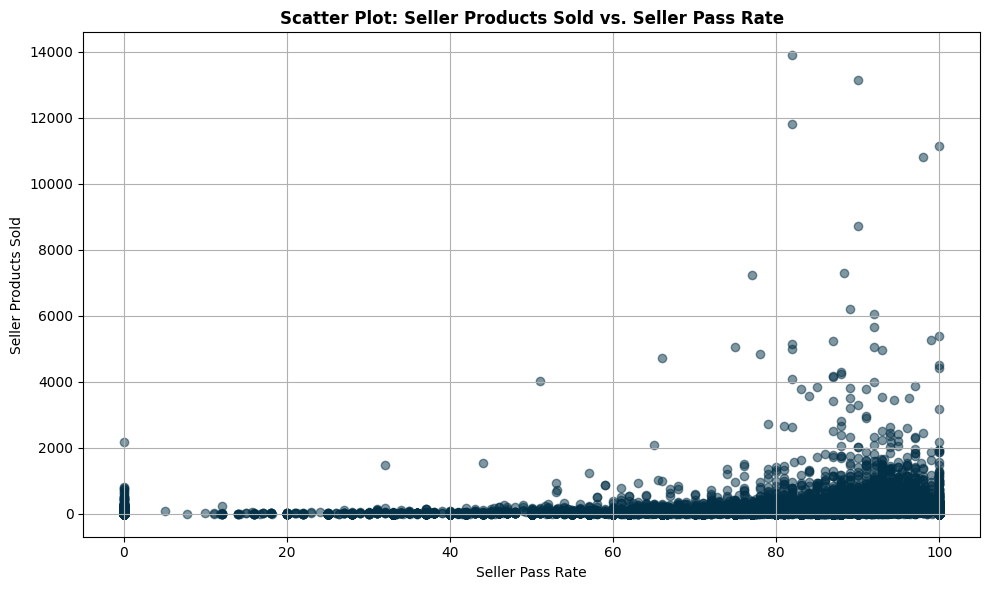

In [51]:
# Filter out the outlier with 80000 products sold
filtered_data = X_train[X_train['seller_products_sold'] < 20000]
filtered_pass_rate = y_train[filtered_data.index]  # Ensure pass rates match filtered data

# Scatter plot with reversed axes
plt.figure(figsize=(10, 6))
plt.scatter(filtered_pass_rate, filtered_data['seller_products_sold'], alpha=0.5, color="#023047")
plt.title("Scatter Plot: Seller Products Sold vs. Seller Pass Rate", fontweight="bold")
plt.xlabel("Seller Pass Rate")
plt.ylabel("Seller Products Sold")
plt.grid(True)
plt.tight_layout()
plt.show()

# the more producst sold, the higher the pass rate -> more experience ? 
# the less products sold, the lower the pass rate 
# also, the ones who sold only few products are more (in terms of how many people)



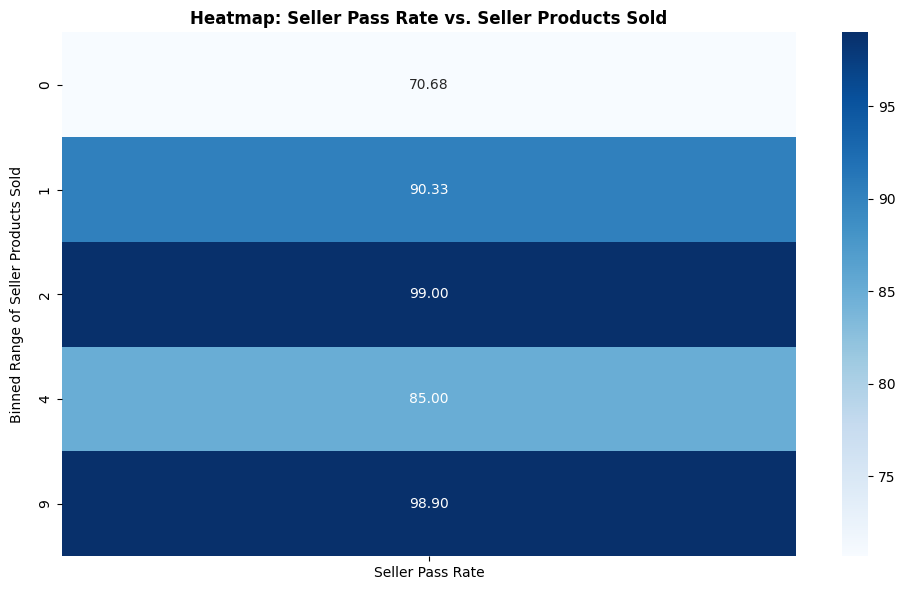

In [61]:
# Bin the data for heatmap
heatmap_data = X_train.copy()
heatmap_data['seller_products_sold_bins'] = pd.cut(heatmap_data['seller_products_sold'], bins=10, labels=False)
heatmap_data['Seller Pass Rate'] = y_train

# Pivot for heatmap
heatmap_pivot = heatmap_data.groupby('seller_products_sold_bins')['Seller Pass Rate'].mean().reset_index()

# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    heatmap_pivot.pivot_table(index='seller_products_sold_bins', values='Seller Pass Rate'),
    cmap="Blues", annot=True, fmt=".2f"
)
plt.title("Heatmap: Seller Pass Rate vs. Seller Products Sold", fontweight="bold")
plt.ylabel("Binned Range of Seller Products Sold", labelpad=10)
plt.tight_layout()
plt.show()


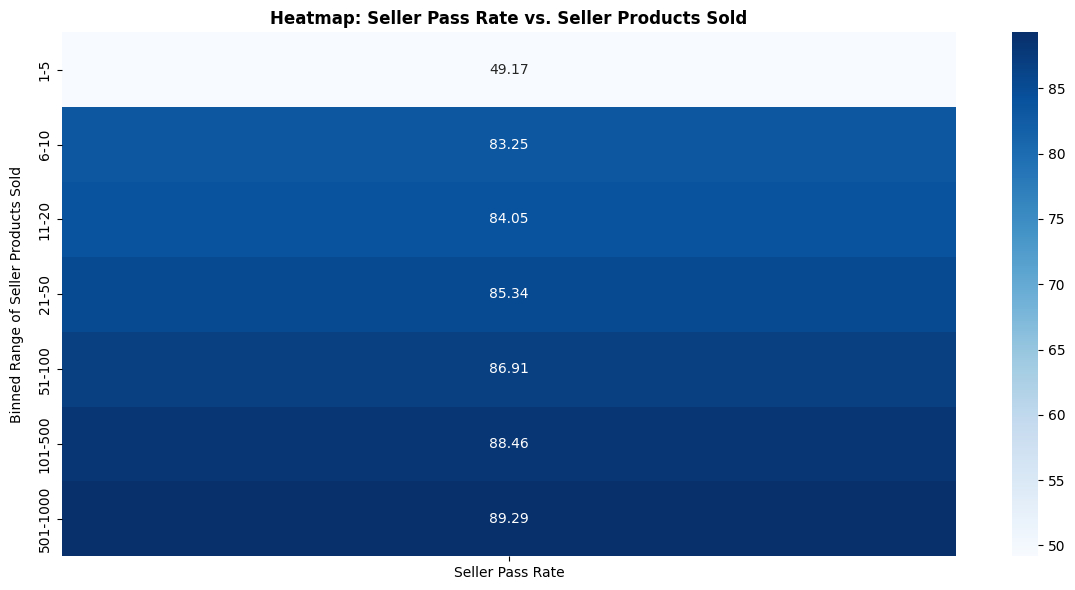

In [59]:

# Step 1: Define custom bins to avoid a "0" bin
bin_edges = [1, 5, 10, 20, 50, 100, 500, 1000]  # Adjust as necessary for your dataset

# Create bin labels to reflect ranges
bin_labels = [
    "1-5", "6-10", "11-20", "21-50", "51-100", "101-500", "501-1000"
]

# Step 2: Bin the data explicitly using these edges and labels
heatmap_data = X_train.copy()
heatmap_data['seller_products_sold_bins'] = pd.cut(
    heatmap_data['seller_products_sold'], bins=bin_edges, labels=bin_labels, include_lowest=True
)
heatmap_data['Seller Pass Rate'] = y_train

# Step 3: Group the data for heatmap visualization
heatmap_pivot = heatmap_data.groupby('seller_products_sold_bins')['Seller Pass Rate'].mean().reset_index()

# Step 4: Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    heatmap_pivot.pivot_table(index='seller_products_sold_bins', values='Seller Pass Rate'),
    cmap="Blues", annot=True, fmt=".2f", linecolor="black"
)
plt.title("Heatmap: Seller Pass Rate vs. Seller Products Sold", fontweight="bold")
plt.ylabel("Binned Range of Seller Products Sold", labelpad=10)
plt.tight_layout()
plt.show()

# constantly shows that the higher the products sold, thee higher the pass rate

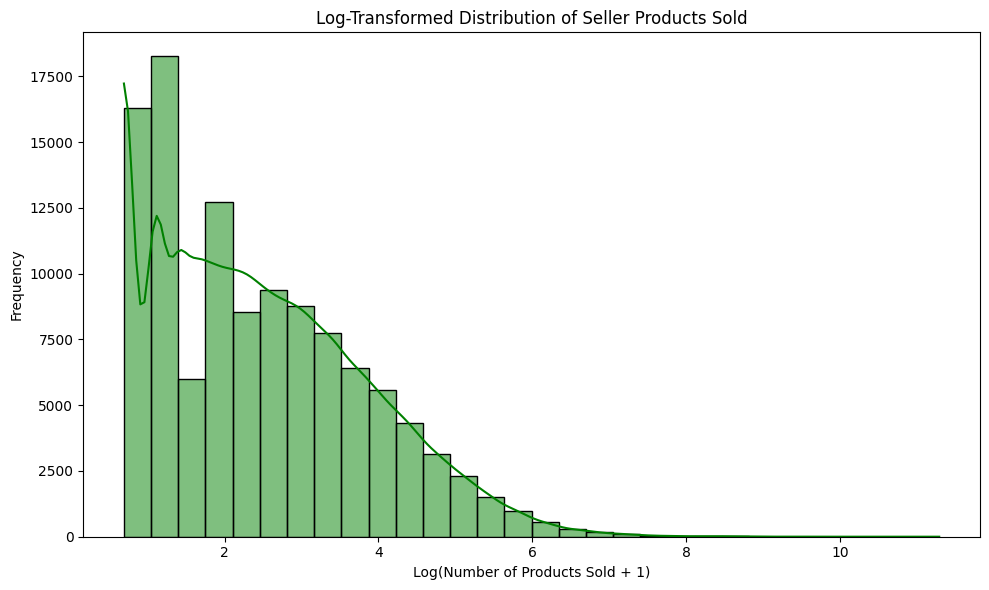

In [43]:
# Log transform the feature
import numpy as np

X_train['log_seller_products_sold'] = np.log1p(X_train['seller_products_sold'])

# Plot the log-transformed histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=X_train, x='log_seller_products_sold', bins=30, kde=True, color='green')
plt.title("Log-Transformed Distribution of Seller Products Sold")
plt.xlabel("Log(Number of Products Sold + 1)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


In [44]:
# Adjust pandas settings to display all rows
pd.set_option('display.max_rows', None)

# Get value counts sorted in ascending order
value_counts_sorted = X_train['seller_products_sold'].value_counts().sort_index()

# Convert to a DataFrame for better display
value_counts_df = value_counts_sorted.reset_index()
value_counts_df.columns = ['Number of Products Sold', 'Frequency']

# Display the sorted value counts
print(value_counts_df)


      Number of Products Sold  Frequency
0                         1.0      16298
1                         2.0      10567
2                         3.0       7694
3                         4.0       5994
4                         5.0       4975
5                         6.0       4112
6                         7.0       3628
7                         8.0       3170
8                         9.0       2880
9                        10.0       2506
10                       11.0       2219
11                       12.0       2073
12                       13.0       1838
13                       14.0       1722
14                       15.0       1538
15                       16.0       1546
16                       17.0       1388
17                       18.0       1300
18                       19.0       1255
19                       20.0       1157
20                       21.0       1075
21                       22.0       1040
22                       23.0        944
23              

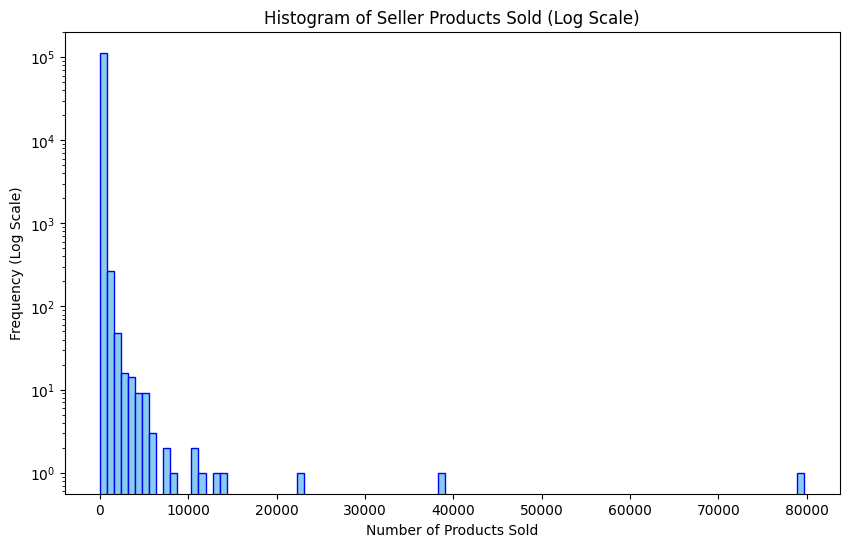

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Plot histogram with log scale
plt.figure(figsize=(10, 6))
plt.hist(X_train['seller_products_sold'], bins=100, color='skyblue', edgecolor='blue', log=True)
plt.title('Histogram of Seller Products Sold (Log Scale)')
plt.xlabel('Number of Products Sold')
plt.ylabel('Frequency (Log Scale)')
plt.show()


# log scale for better visualization